In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit

<h2> NLM with two nests : measured (1,2) and flat (3,4,5) </h2>

In [2]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [3]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
# lambda_n = 1 / mu_n is a measure of the degree of independence in unobserved utility among
# the alternatives in nest n.
# It should be between 0 and 1 with lambda_n = 1 indicating full independence.
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]


In [4]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone)

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -0.378246              0.125454    -3.015006  2.723024e-03
1            ASC_3  0.893446              0.171565     5.207627  2.980374e-07
2            ASC_4  0.847293              0.393757     2.151815  3.197195e-02
3            ASC_5  1.405502              0.259374     5.418828  1.004633e-07
4        BETA_COST -1.490024              0.252883    -5.892149  7.739943e-09
5  lambda_measured  0.484798              0.139705     3.470160  5.730726e-04
6      lambda_flat  0.436216              0.121307     3.595981  3.609402e-04
AIC: 960.4386663193137
BIC: 988.9499780580165


---
---
---
---
---

<h2> Applying DIB algorithm </h2>

<h3> P_i corresponds to p(y=i | x) because we have different probabilities for each individual. </h3>

In [5]:
# Computation of p(x)

data_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Function to compare rows with a reference row
def count_same_rows(df):
    row_counts = {}

    for index, row in df.iterrows():
        # Convert the row to a tuple to make it hashable
        row_tuple = tuple(row)
        
        # Count the occurrences of the row in the dataframe
        if row_tuple in row_counts:
            row_counts[row_tuple] += 1
        else:
            row_counts[row_tuple] = 1
            
    return row_counts

# Count occurrences of each row
row_counts = count_same_rows(data_logcost)

# Add a new column with probabilities
total_rows = len(data_logcost)
data_logcost['probability'] = data_logcost.apply(lambda row: row_counts[tuple(row)] / total_rows, axis=1)
data_logcost.head()


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_69537/1755510660.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['probability'] = data_logcost.apply(lambda row: row_counts[tuple(row)] / total_rows, axis=1)


,logcost1,logcost2,logcost3,logcost4,logcost5,probability
0,1.761300,1.754404,2.545531,13.815511,3.147595,0.002304
1,1.258461,1.754404,2.507972,13.815511,3.147595,0.002304
2,1.627278,1.754404,2.439735,13.815511,3.342155,0.002304
3,1.558145,1.754404,2.347558,13.815511,3.342155,0.002304
4,2.145931,1.953028,2.662355,13.815511,3.342155,0.002304


In [6]:
# Computation of p(x,y)
p_x = data_logcost['probability'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

<h2> Modified version of the DIB algorithm where the maximum number of clusters is the number of alternatives, not the number of individuals </h2>

In [7]:
from functions_geom_DIB import geom_DIB_on_alternatives

<h3> We try to apply IB/DIB to p(x,y) = p(y|x)p(x) where 

- p(y|x) comes from the P_i
- p(x) comes from the empirical distribution
</h3>

Iteration: 1 out of 5000


Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 5000
Iteration: 40 out of

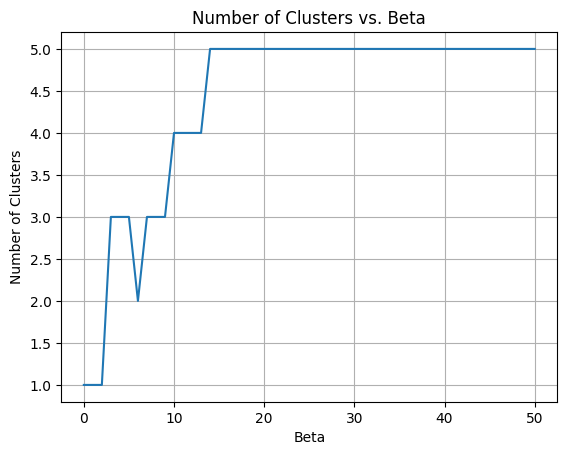

In [8]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [9]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=1e10, max_iter=5000, threshold=1e-30)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000


In [10]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
num_clusters

5

In [11]:
# Create new column choice_nest which is 1 if choice= 1 or 2, and 2 otherwise
data['choice_nest'] = np.where(data['choice'].isin([1, 2]), 1, 2)
data['cluster'] = np.argmax(q_t_given_x, axis=1)
data['cluster'].value_counts()

cluster
1    145
0    136
3    106
4     38
2      9
Name: count, dtype: int64

In [12]:
data['choice_nest'].value_counts()

choice_nest
2    238
1    196
Name: count, dtype: int64

In [13]:
data_results = data[['P_nest_measured','P_nest_flat', 'P_1','P_2', 'P_3', 'P_4', 'P_5', 'choice', 'choice_nest', 'cluster']]

data_results['max_proba'] = data_results[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
data['max_proba'] = data_results['max_proba']

#create a dataframe from mismatched_rows
data_results = pd.DataFrame(data_results)

# Print the mismatched rows
data_results.head()

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_69537/80090789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_results['max_proba'] = data_results[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)


,P_nest_measured,P_nest_flat,P_1,P_2,P_3,P_4,P_5,choice,choice_nest,cluster,max_proba
0,0.577870,0.422130,0.178980,0.398890,0.298604,0.0,0.123526,2,1,1,2
1,0.655481,0.344519,0.444340,0.211141,0.252604,0.0,0.091915,3,2,3,1
2,0.578875,0.421125,0.233773,0.345103,0.366742,0.0,0.054382,1,1,3,3
3,0.559853,0.440147,0.255216,0.304637,0.397161,0.0,0.042986,3,2,3,3
4,0.538114,0.461886,0.108763,0.429351,0.350655,0.0,0.111231,3,2,1,2


In [14]:
# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_results.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
cluster_counts

choice,1,2,3,4,5
cluster,,,,,
0,22,60,53,0,1
1,15,41,68,0,21
2,2,1,3,3,0
3,33,20,50,0,3
4,1,1,4,0,32


In [15]:
cluster_counts2 = data_results.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
cluster_counts2

max_proba,1,2,3,4,5
cluster,,,,,
0,0,0,136,0,0
1,0,82,57,0,6
2,0,0,7,2,0
3,48,3,55,0,0
4,0,0,1,0,37


In [16]:
nest_counts = data_results.groupby(['choice', 'max_proba']).size().unstack(fill_value=0)
nest_counts

max_proba,1,2,3,4,5
choice,,,,,
1,16,13,43,0,1
2,12,27,82,0,2
3,19,32,121,1,5
4,0,0,2,1,0
5,1,13,8,0,35


---
---
---
---
---

In [17]:
from functions_geom_DIB import DIB_curve_on_alternatives

Beta: 1 out of 21
Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Ite

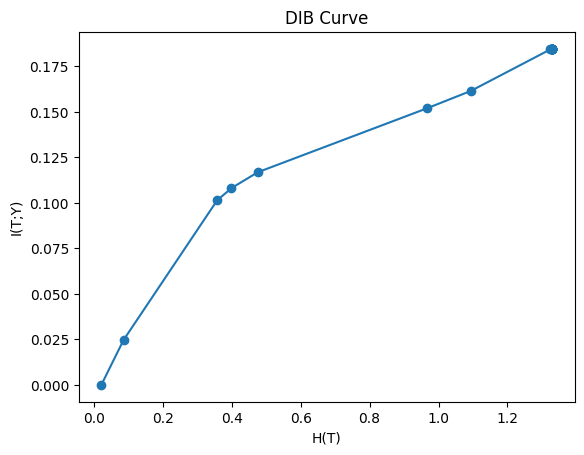

In [18]:
betas = np.linspace(0, 50, 21)
DIB_curve_on_alternatives(p_xy, beta_values=betas, max_iter=5000, threshold=1e-4)